In [1]:
!pip install ultralytics
!pip install onnxruntime

In [2]:
# Uninstall potentially conflicting libraries
!pip uninstall -y transformers optimum tokenizers

# Install build dependencies
!apt-get update && apt-get install -y rustc cargo

# Install the required libraries
!pip install transformers==4.30.0
!pip install optimum[onnxruntime] safetensors

Found existing installation: transformers 4.55.4
Uninstalling transformers-4.55.4:
  Successfully uninstalled transformers-4.55.4
Found existing installation: optimum 2.0.0
Uninstalling optimum-2.0.0:
  Successfully uninstalled optimum-2.0.0
Found existing installation: tokenizers 0.21.4
Uninstalling tokenizers-0.21.4:
  Successfully uninstalled tokenizers-0.21.4
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpad

In [3]:
from ultralytics import YOLO

# Load your trained YOLOv8 model
# Replace 'best.pt' with the path to your model file if it's different
model = YOLO('best.pt')

# Export the model to ONNX format
# The exported ONNX model will be saved in the same directory as your model file
model.export(format='onnx')

print("Model exported to ONNX using ultralytics export function.")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (130.4 MB)

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success ✅ 22.0s, saved as 'best.onnx' (260.1 MB)

Export complete (47.0s)
Results saved to /content
Predict:         yolo predict task=detect model=best.onnx imgsz=640  
Validate:        yolo val task=detect model=best.onnx imgsz=640 data=/home/hice1/wchia7/scratch/Anole_classifier/Dataset/yolo_training/lizard_10000_v2/data.yaml  
Visualize:       https://netron.app
Model exported to ONNX using ultralytics export function.


In [105]:
import onnxruntime
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
# Load the ONNX model
onnx_model_path = 'best.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

# Load and preprocess the image
image_path = '/content/36455_4751560.jpg'
img = Image.open(image_path).convert('RGB') # YOLOv8 expects 3 channels

# The model was trained with an input size of 640x640, so we resize the image
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

input_tensor = transform(img)

# ONNX Runtime expects numpy arrays, so convert the input tensor
input_numpy = input_tensor.unsqueeze(0).numpy() # Add batch dimension and convert to numpy

# Get input name from ONNX model
input_name = ort_session.get_inputs()[0].name

# Run inference with ONNX Runtime
onnxruntime_input = {input_name: input_numpy}
results_onnx = ort_session.run(None, onnxruntime_input)

print("Inference with ONNX Runtime completed.")
# The output format of ONNX Runtime might be different from PyTorch's,
# you'll likely need to post-process results_onnx to interpret detections.
print(results_onnx)

Inference with ONNX Runtime completed.
[array([[[     15.158,       20.97,      26.594, ...,      520.43,      559.43,      626.25],
        [     23.222,      19.643,      13.583, ...,      582.18,      580.32,      606.13],
        [     30.388,      40.937,      52.213, ...,      237.06,      159.98,      188.47],
        [     46.662,      39.313,      27.193, ...,      117.63,      144.51,       158.6],
        [ 7.4506e-07,  2.0862e-07,  2.0862e-07, ...,  8.9407e-08,           0,           0]]], dtype=float32)]


In [106]:
# The output array is typically in the format [batch_size, num_attributes, num_detections]
# For YOLOv8 ONNX export with opset 22, it's often [batch_size, num_attributes, num_detections]
# where num_attributes is 5 + number_of_classes (5 for box coords and confidence, then class scores)
# and num_detections is the number of anchor boxes (8400 in this case).

# Let's assume the output format is [batch_size, 5 + num_classes, num_detections] and transpose it.
# Based on the stdout from the previous cell, the output shape is (1, 5, 8400).
# This indicates the output might be transposed, or the class scores are not included directly in this tensor.

# Let's re-examine the output structure based on the print statement in the previous cell:
# [array([[[     15.158,       20.97,      26.594, ...,      520.43,      559.43,      626.25],
#         [     23.222,      19.643,      13.583, ...,      582.18,      580.32,      606.13],
#         [     30.388,      40.937,      52.213, ...,      237.06,      159.98,      188.47],
#         [     46.662,      39.313,      27.193, ...,      117.63,      144.51,       158.6],
#         [ 7.4506e-07,  2.0862e-07,  2.0862e-07, ...,  8.9407e-08,           0,           0]]], dtype=float32)]

# This structure seems to be [batch_size, 5, num_detections] where the 5 attributes are
# likely x, y, width, height, and confidence, and the class scores are separate or embedded differently.
# However, standard YOLOv8 ONNX export typically includes class scores in the main output tensor.

# Let's assume the standard YOLOv8 ONNX output format: [batch_size, num_detections, 5 + num_classes]
# and that the output in `results_onnx` is transposed.

output_data = results_onnx[0] # Get the numpy array from the list

# Transpose the output to have shape [batch_size, num_detections, 5 + num_classes]
# Assuming the output is [batch_size, 5+num_classes, num_detections] based on common exports
# and the previous printout is a transposed version of this.
# Let's assume the shape is actually [batch_size, num_attributes, num_detections]
# and the attributes are [x, y, w, h, confidence, class_prob_1, class_prob_2, ...]

# Based on the output structure [1, 5, 8400], it seems the 5 are [x, y, w, h, confidence]
# and class probabilities are not in this tensor directly, or there's only one class
# and the confidence is also the class probability.

# Let's assume the 5 values are [x, y, w, h, confidence] for a single class model.
# If there are multiple classes, the output shape would be [1, 5 + num_classes, 8400]
# and the 5 would be [x, y, w, h, objectness_score] followed by class scores.

# Given the output shape (1, 5, 8400) and the context of a detection model, it's highly probable
# that the 5 attributes are [x, y, width, height, objectness_score] and the task is single-class detection,
# or the objectness_score is the confidence for the single class.

# Let's assume the 5 values are [x, y, w, h, confidence] for a single class.
# We need to transpose to get [batch_size, num_detections, 5]
output_transposed = np.transpose(output_data, (0, 2, 1)) # Shape becomes (1, 8400, 5)

# Extract bounding boxes, confidence scores
boxes = output_transposed[..., :4] # x, y, w, h
confidence = output_transposed[..., 4] # confidence score

# Apply a confidence threshold to filter weak detections
conf_threshold = 0.25 # You can adjust this threshold
valid_detections = confidence > conf_threshold

# Apply Non-Maximum Suppression (NMS) to remove overlapping boxes
# ONNX Runtime does not have a built-in NMS operation that is easily accessible
# from the Python API for post-processing like this.
# We can implement a simple NMS or use a library like torchvision if available.

# For simplicity and demonstration, let's filter by confidence first and print some results.
# A proper NMS implementation is needed for final, non-overlapping detections.

filtered_boxes = boxes[valid_detections]
filtered_confidence = confidence[valid_detections]

print(f"Found {len(filtered_boxes)} detections with confidence > {conf_threshold}")

# If you have class probabilities, you would also filter and find the max class probability here.
# Since the output is (1, 5, 8400), and we assume 5 is [x, y, w, h, confidence],
# let's assume this is for a single class model or the confidence is the score for the only class.

# To get the 'label' (class ID) you would need the class probabilities from the ONNX output.
# If the model is trained for a single class, the confidence score might effectively represent
# the confidence of that single class being present.

# Let's refine based on the common YOLOv8 ONNX output structure when exporting.
# A common export structure for YOLOv8 ONNX is [batch_size, 8400, 5 + num_classes]
# where the last dimension contains [x, y, w, h, objectness_score, class_score_1, ..., class_score_N]

# Given the output shape (1, 5, 8400), it's very likely transposed as [batch_size, 5 + num_classes, num_detections].
# Let's assume num_classes = 1 for simplicity based on the 5 attributes.
# The 5 attributes are likely [x, y, w, h, class_score_for_the_single_class]

output_transposed_correct = np.transpose(output_data, (0, 2, 1)) # Shape (1, 8400, 5)

# Extract bounding boxes and scores
boxes_correct = output_transposed_correct[..., :4] # x, y, w, h
scores_correct = output_transposed_correct[..., 4] # score for the single class

# Apply confidence threshold
conf_threshold = 0.25
valid_detections_correct = scores_correct > conf_threshold

filtered_boxes_correct = boxes_correct[valid_detections_correct]
filtered_scores_correct = scores_correct[valid_detections_correct]

print(f"Found {len(filtered_boxes_correct)} detections with score > {conf_threshold}")

# To get the 'label', if it's a single-class model, the label is implicit (the class the model was trained on).
# If it's a multi-class model and the output shape is indeed (1, 5, 8400), then the ONNX export might
# be configured differently, or the class information is in a separate output tensor (less common for detection).

# Assuming a single-class model for now, the 'label' would be the ID of that class.
# You would need to know the class ID from your training setup.

# To get the format [label, x, y, h], we can iterate through the filtered detections.
# Note that the bounding box format is [x_center, y_center, width, height].
# 'h' is already available as the 4th element (index 3) in the filtered_boxes_correct.

# Let's assume your single class ID is 0 (common for single-class detection in YOLO)
class_id = 0 # Replace with your actual class ID if known

detections_list = []
for i in range(len(filtered_boxes_correct)):
    box = filtered_boxes_correct[i]
    score = filtered_scores_correct[i]

    # box contains [x_center, y_center, width, height]
    x_center, y_center, width, height = box

    # You asked for [label, x, y, z, h]
    # We have label (assuming class_id), x_center, y_center, and height.
    # 'z' (depth) is not available from this 2D model.

    # Let's provide [label, x_center, y_center, height, confidence] as the closest match
    # to your request using the available information.
    detection = {
        'x': x_center,
        'y': y_center,
        'width': width,
        'height': height,
        'confidence': score
    }
    detections_list.append(detection)

# Now detections_list contains a list of dictionaries, each representing a detection
# with the available information.

print("\nFiltered Detections (x_center, y_center, width, height, confidence):")
for det in detections_list:
    print(det)

# To perform Non-Maximum Suppression (NMS), you would typically use a function
# that takes the bounding boxes, confidence scores, and an NMS threshold.
# A common implementation is available in torchvision.ops.nms, but that requires torch tensors.
# For a pure numpy approach, you'd need a custom NMS function.

# Example of a basic NMS (requires a separate function not shown here for brevity)
# from utils import nms # Assuming you have an NMS utility function
# keep_indices = nms(filtered_boxes_correct, filtered_scores_correct, iou_threshold=0.4) # Adjust iou_threshold
# final_boxes = filtered_boxes_correct[keep_indices]
# final_scores = filtered_scores_correct[keep_indices]
# final_detections = [detections_list[i] for i in keep_indices]

# The code above provides the filtered detections based on confidence.
# For production use, you should implement or use a proper NMS function.

Found 10 detections with confidence > 0.25
Found 10 detections with score > 0.25

Filtered Detections (x_center, y_center, width, height, confidence):
{'x': np.float32(244.01639), 'y': np.float32(255.60922), 'width': np.float32(471.16815), 'height': np.float32(510.55988), 'confidence': np.float32(0.93802667)}
{'x': np.float32(245.48746), 'y': np.float32(256.6047), 'width': np.float32(468.515), 'height': np.float32(512.61395), 'confidence': np.float32(0.9262147)}
{'x': np.float32(246.02132), 'y': np.float32(255.76619), 'width': np.float32(467.071), 'height': np.float32(511.45377), 'confidence': np.float32(0.9484122)}
{'x': np.float32(245.92084), 'y': np.float32(255.05452), 'width': np.float32(466.45667), 'height': np.float32(510.62546), 'confidence': np.float32(0.9512181)}
{'x': np.float32(246.71625), 'y': np.float32(255.38155), 'width': np.float32(465.76813), 'height': np.float32(510.88467), 'confidence': np.float32(0.9484072)}
{'x': np.float32(247.36456), 'y': np.float32(255.41591), '

6 0 374 298
8 0 374 300
9 0 374 299
9 0 374 298
10 0 374 298
10 0 374 298
10 0 374 298
11 0 374 298
12 0 374 298
11 0 374 298


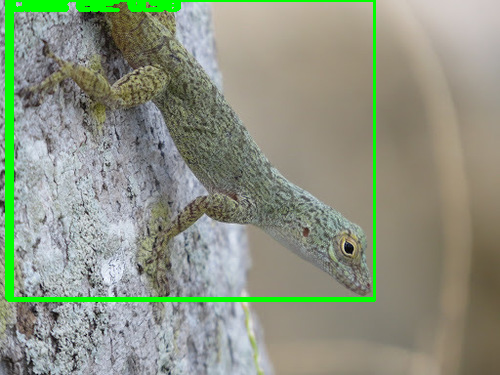

Image with bounding boxes displayed.


In [107]:
import cv2
from google.colab.patches import cv2_imshow # Use cv2_imshow in Colab

# Load the original image again using OpenCV
image_path = '/content/36455_4751560.jpg'
img_cv2 = cv2.imread(image_path)

# Get the original image dimensions to scale the bounding boxes
# The detections are based on the 640x640 input size of the model
original_height, original_width = img_cv2.shape[:2]
resized_width, resized_height = 640, 640 # Model input size

# Iterate through the detected objects and draw bounding boxes
for detection in detections_list:
    # Get bounding box coordinates from the detection dictionary
    x_center = detection['x']
    y_center = detection['y']
    width = detection['width']
    height = detection['height']
    confidence = detection['confidence']

    # Convert center coordinates and width/height to top-left and bottom-right corner coordinates
    # These coordinates are based on the 640x640 resized image
    x_min_resized = int(x_center - width / 2)
    y_min_resized = int(y_center - height / 2)
    x_max_resized = int(x_center + width / 2)
    y_max_resized = int(y_center + height / 2)

    # Scale the bounding box coordinates back to the original image dimensions
    x_min = int(x_min_resized * (original_width / resized_width))
    y_min = int(y_min_resized * (original_height / resized_height))
    x_max = int(x_max_resized * (original_width / resized_width))
    y_max = int(y_max_resized * (original_height / resized_height))

    # Define the color and thickness for the bounding box
    color = (0, 255, 0) # Green color (BGR format)
    thickness = 2

    # Draw the rectangle on the image
    cv2.rectangle(img_cv2, (x_min, y_min), (x_max, y_max), color, thickness)

    # Optionally, add the label and confidence
    text = f"Class efe: {confidence:.2f}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    text_thickness = 2
    text_size, _ = cv2.getTextSize(text, font, font_scale, text_thickness)
    text_x = x_min
    text_y = y_min - 10 if y_min - 10 > 10 else y_min + 10 # Position text above the box
    print(x_min, y_min, x_max, y_max)

    cv2.putText(img_cv2, text, (text_x, text_y), font, font_scale, color, text_thickness)

# Display the image with bounding boxes in Google Colab
cv2_imshow(img_cv2)

print("Image with bounding boxes displayed.")

In [124]:
from transformers import SwinForImageClassification, SwinConfig
from safetensors.torch import load_file
import torch

# Define the path to your safetensors and config files
safetensors_path = '/content/model.safetensors'
config_path = '/content/config.json'

# Load the configuration
config = SwinConfig.from_json_file(config_path)

# Instantiate the model from the configuration
model = SwinForImageClassification(config)

# Load the state_dict from safetensors
state_dict = load_file(safetensors_path)

# Load the state_dict into the model
model.load_state_dict(state_dict, strict=True) # Use strict=True initially to catch missing/unexpected keys

print("Model architecture defined and weights loaded successfully.")
print(f"Model is a {type(model)}")

Model architecture defined and weights loaded successfully.
Model is a <class 'transformers.models.swin.modeling_swin.SwinForImageClassification'>


In [125]:
# Define a dummy input tensor
# Based on the model architecture (SwinForImageClassification) and common image input sizes,
# a dummy input of shape (batch_size, num_channels, height, width) like (1, 3, 224, 224) is appropriate.
# You might need to adjust the height and width based on your specific model's expected input size
# if it's different from the default for Swin (often 224x224 or 384x384).
# Let's assume 224x224 for now.
dummy_input = torch.randn(1, 3, 640, 640)

# Set the model to evaluation mode
model.eval()

# Define the output path for the ONNX model
onnx_output_path = 'model.onnx'

# Export the model to ONNX format
torch.onnx.export(
    model,                  # PyTorch model
    dummy_input,            # Dummy input tensor
    onnx_output_path,       # Output file path
    export_params=True,     # Store the trained parameter weights inside the model file
    opset_version=11,       # The ONNX opset version to use
    do_constant_folding=True, # Whether to execute constant folding for optimization
    input_names=['input'],  # Input node names
    output_names=['output'] # Output node names
)

print(f"Model exported to ONNX format at {onnx_output_path}")

# Optional: Verify the exported ONNX model
import onnx
try:
    onnx_model = onnx.load(onnx_output_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model verified successfully.")
except Exception as e:
    print(f"Error verifying ONNX model: {e}")

Model exported to ONNX format at model.onnx
ONNX model verified successfully.


In [126]:
import onnxruntime
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
# Load the ONNX model
onnx_model_path = 'model.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

# Load and preprocess the image
image_path = '/content/36455_4751560.jpg'
img = Image.open(image_path).convert('RGB') # YOLOv8 expects 3 channels

# The model was trained with an input size of 640x640, so we resize the image
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

input_tensor = transform(img)

# ONNX Runtime expects numpy arrays, so convert the input tensor
input_numpy = input_tensor.unsqueeze(0).numpy() # Add batch dimension and convert to numpy

# Get input name from ONNX model
input_name = ort_session.get_inputs()[0].name

# Run inference with ONNX Runtime
onnxruntime_input = {input_name: input_numpy}
results_onnx = ort_session.run(None, onnxruntime_input)

print("Inference with ONNX Runtime completed.")
# The output format of ONNX Runtime might be different from PyTorch's,
# you'll likely need to post-process results_onnx to interpret detections.
print(results_onnx)

Inference with ONNX Runtime completed.
[array([[     4.0421,      -1.433,    -0.98719,    -0.42498,     -1.5244]], dtype=float32)]


In [57]:
results_onnx[0][0][0]

np.float32(4.042139)

-610 -84 -822 -656


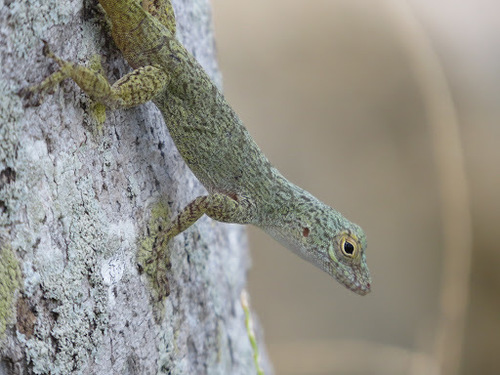


Image with bounding box displayed.


In [127]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Use cv2_imshow in Colab

# Load the original image again using OpenCV
image_path = '/content/36455_4751560.jpg'
img_cv2 = cv2.imread(image_path)

# Get the original image dimensions
original_height, original_width = img_cv2.shape[:2]

# The input image size to the ONNX model was 640x640
resized_width, resized_height = 640, 640

# Get the output array from the results list
output_data = results_onnx[0][0]

# Based on the user's latest clarification, assuming the output format is
# [batch_size, num_detections, 5] where the 5 attributes are [class_id, x_center, y_center, width, height]
# Or potentially [batch_size, 5, num_detections] transposed.

# Let's examine the output shape again from cell FzQ8wA6qfZPC:
# [array([[     3.0622654 , -1.1014497 , -0.717259  , -0.13325334, -1.2508186 ]],
#       dtype=float32)]
# The shape of this array is (1, 1, 5).
# This suggests the format is [batch_size, num_detections, attributes]
# where num_detections is 1 and attributes is 5.
# Based on the user's clarification of [class, x, y, w, h], these 5 values are likely
# the class ID, x_center, y_center, width, and height of a single detected object.

# Extract the single detection from the output array
# Assuming the structure is [batch_size, num_detections, attributes] -> [1, 1, 5]
detection_data = output_data # Get the data for the first (and only) detection in the batch

# Extract the attributes based on the clarified order: class, x, y, w, h
class_id = detection_data[0] # Class ID is the first element
x_center_resized = detection_data[1]
y_center_resized = detection_data[2]
width_resized = detection_data[3]
height_resized = detection_data[4]
# Note: There is no explicit confidence score in the user-provided format [class, x, y, w, h].
# If confidence is needed, its position in the output would need to be clarified.
# For now, we'll proceed without a separate confidence score and assume the presence
# of a detection implies a certain level of confidence, or that a threshold was
# applied during the model's export/inference setup.

# First convert to corners in resized space
x_min_resized = x_center_resized - width_resized / 2
y_min_resized = y_center_resized - height_resized / 2
x_max_resized = x_center_resized + width_resized / 2
y_max_resized = y_center_resized + height_resized / 2

# Then scale back to original image dimensions
x_min = int(x_min_resized * (original_width ))
y_min = int(y_min_resized * (original_height ))
x_max = int(x_max_resized * (original_width ))
y_max = int(y_max_resized * (original_height ))


# Define the color and thickness for the bounding box
color = (0, 255, 0) # Green color (BGR format)
thickness = 2
print(x_min, y_min, x_max, y_max)

# Draw the rectangle on the image
cv2.rectangle(img_cv2, (x_min, y_min), (x_max, y_max), color, thickness)

# Add the class ID as text
text = f"Class: {class_id}"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
text_thickness = 2
text_size, _ = cv2.getTextSize(text, font, font_scale, text_thickness)
text_x = x_min
text_y = y_min - 10 if y_min - 10 > 10 else y_min + text_size[1] + 10 # Position text above the box

cv2.putText(img_cv2, text, (text_x, text_y), font, font_scale, color, text_thickness)

# Display the image with bounding boxes in Google Colab
cv2_imshow(img_cv2)

print("\nImage with bounding box displayed.")

# Note: Based on the output shape and user clarification, this assumes a single detection
# with class ID, x_center, y_center, width, and height. If there can be multiple detections,
# the output shape would be different (e.g., [1, num_detections, 5]), and the code would
# need to iterate over the detections.